# Практическая работа №1

## Разработка сверточной нейронной сети
с использованием MXNet или PyTorch

Выполнила студентка группы 2238М1ПМкн1 Журилова Анастасия Сергеевна

Цель работы:

Изучить **разработку** и **настройку сверточной нейронной сети** для задачи классификации изображений на наборе данных Cifar-10 с использованием MXNet или PyTorch. Необходимо подобрать гиперпараметры.

Задачи:

1) Загрузка данных

* предобработка данных

2) Визуализация данных

* Проверка корректности загрузки данных (Демонстрация изображений и меток классов)

* Проверка совпадения размерностей загруженных данных

3) Построение архитектуры

* Вывод информации об архитектуре

* Выполнить визуализацию сети

4) Обучение модели

* Вывод информации о параметрах алгоритма обучения

* Вывести **ошибку классификации** на обучении

* Вывести время обучения каждой эпохи

* Вывести **общее время обучения сети**

5) Тестирование модели

* Вывести **ошибку классификации** на тестировании

*) Учитывать возможность перезапуска кода в терминал-классе

#### 0) Подключение библиотек

In [1]:
# использование pytorch
!pip install torchview
# для графики CNN
!pip install graphviz

In [2]:
# pytorch для данных и CNN
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import numpy as np
import os

# визуализация данных
from matplotlib import pyplot as plot

# визуализация CNN
import graphviz
from torchview import draw_graph

# подсчёт времени работы CNN
import time

%matplotlib inline

#### 1) Загрузка данных

Будем использовать данные Cifar-10.

Набор данных имеет в общей сложности 60 000 цветных изображений.
Картинки разделены на 10 категорий, каждая 6000 изображений.

Для обучения насчитывается 50 000, остальные 10 000 используются для тестирования.

Это изображения с размерами [3 x 32 x 32], что означает, что изображение трёхканальное (RGB) с разрешением 32 на 32 пикселя.

In [3]:
directory_name = os.getcwd()

Изначально, изображения представлены в виде PIL.Image (эта библиотека предназначенна для работы с растровой графикой).

Соответственно, необходимо перевести этот формат в Tensor pyTorch.

При переводе изображения в tensor происходит нормализация в соответствии с максимальным значением пикселя: т.е. пиксели имели значение от 0 до 255, а стали варьироваться в промежутке от 0. до 1.

Можно провести, ещё одну нормализацию таким образом, чтобы каждый канал имел нулевое среднее значение и единичное стандартное отклонение.

Для этого необходимо вычислить среднее значение и стандартное отклонение для каждого канала набора данных.

In [4]:
# Праметры нормализации
norm_params_for_tensor = ((0.4915, 0.4823, 0.4468), (0.247, 0.2435, 0.2616))

Так же, можно применить ещё методы "улучшения" данных для последующего обучения.

Можно использовать серию случайных изменений обучающих изображений для генерации похожих, но разных обучающих выборок.

Этот подход может помочь уменьшить зависимость модели от определенных атрибутов, тем самым улучшая способность модели к обучению.

В моём случае, я применю случайный горизонтальный переворот [torchvision.transforms.RandomHorizontalFlip()] и случайную обрезку по краям [torchvision.transforms.RandomCrop]

Изображение обрезается по-разному, чтобы интересующий объект появлялся в разных положениях, тем самым уменьшая зависимость модели от положения объекта.

Предобработка данных.

Необходимо провести несколько операций:

* Случайная обрезка изображений с дополнением необходимых границ

* Случайный горизонтальный переворот

* To Tensor()

* Нормализация данных

Так как первые две операции необходимы для улучшения обучения модели, то на тестовых данных применяем только две последние операции.

In [5]:
# Загрузка данных
# Тренировочные данные
train_dataset = torchvision.datasets.CIFAR10(
    root = directory_name,
    train = True,
    download = True,
    transform = torchvision.transforms.Compose([
      torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
      torchvision.transforms.RandomHorizontalFlip(),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(*norm_params_for_tensor, inplace=True),
    ]),
)


# Тестовые данные
test_dataset = torchvision.datasets.CIFAR10(
    root = directory_name,
    train = False,
    download = True,
    transform = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(*norm_params_for_tensor, inplace=True),
    ]),
)

100%|██████████| 170498071/170498071 [00:03<00:00, 49062245.44it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


#### 2) Визуализация данных

* Проверка корректности загрузки данных (Демонстрация изображений и меток классов)

* Проверка совпадения размерностей загруженных данных

Проверка совпадения размерностей загруженных данных

In [6]:
# Размерность данных
print(f'Количество объектов в тренировочной выборке: {len(train_dataset)}')
print(f'Количество объектов в тестовой выборке: {len(test_dataset)}')
print()
print(f'Размерность изображения (X) = [{train_dataset[0][0].shape[0]} канала, {train_dataset[0][0].shape[1]} x {train_dataset[0][0].shape[2]}]')
print(f'Тип данных изображения (X) = {train_dataset[0][0].numpy().dtype}')
print()
print(f'Вид метки класса (Y) = ({train_dataset[0][1]})')
print(f'Тип данных метки класса (Y) = {type(train_dataset[0][1])}')

Количество объектов в тренировочной выборке: 50000
Количество объектов в тестовой выборке: 10000

Размерность изображения (X) = [3 канала, 32 x 32]
Тип данных изображения (X) = float32

Вид метки класса (Y) = (6)
Тип данных метки класса (Y) = <class 'int'>


Проверка корректности загрузки данных (Демонстрация изображений и меток классов)

In [7]:
def reverse_normalization(image, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return image * stds + means


# Показ изображений
def show_images(images, title):
    num_showed_imgs_x_figure = 8
    num_showed_imgs_y_figure = 3

    class_name = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

    figsize = (16, 6)
    fig, axes = plot.subplots(num_showed_imgs_y_figure, num_showed_imgs_x_figure, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])

    for i, ax in enumerate(axes.flat):
        img = reverse_normalization(images[i][0], norm_params_for_tensor[0], norm_params_for_tensor[1])
        img = img.numpy().transpose(1, 2, 0)
        title_class_name = str(images[i][1]) + " - " + class_name[images[i][1]]
        ax.set_title(title_class_name)
        ax.imshow((img * 255).astype('uint8'))

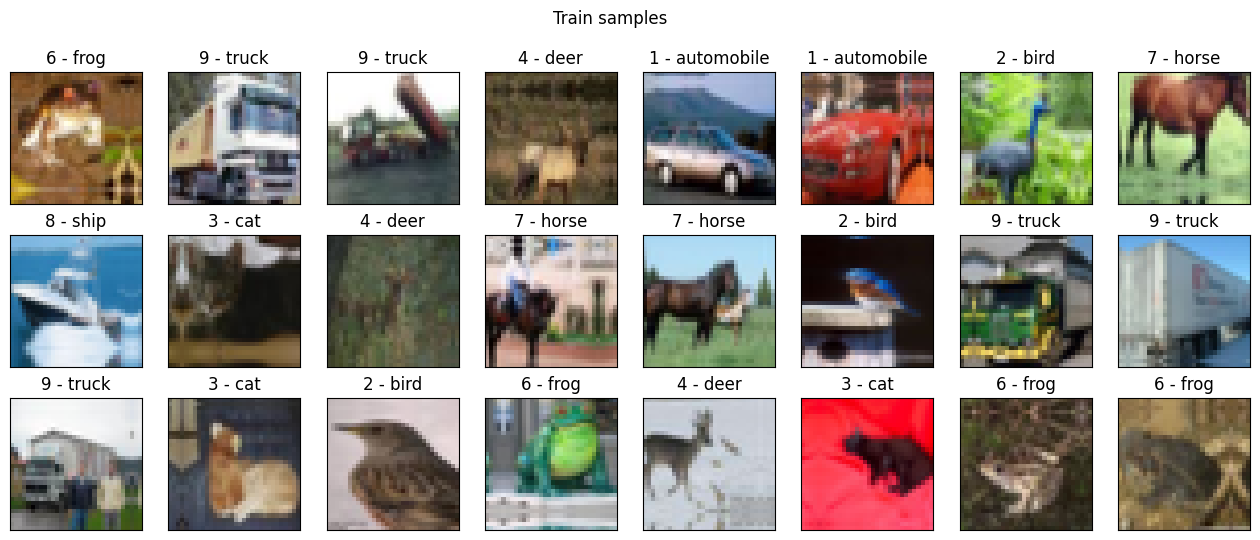

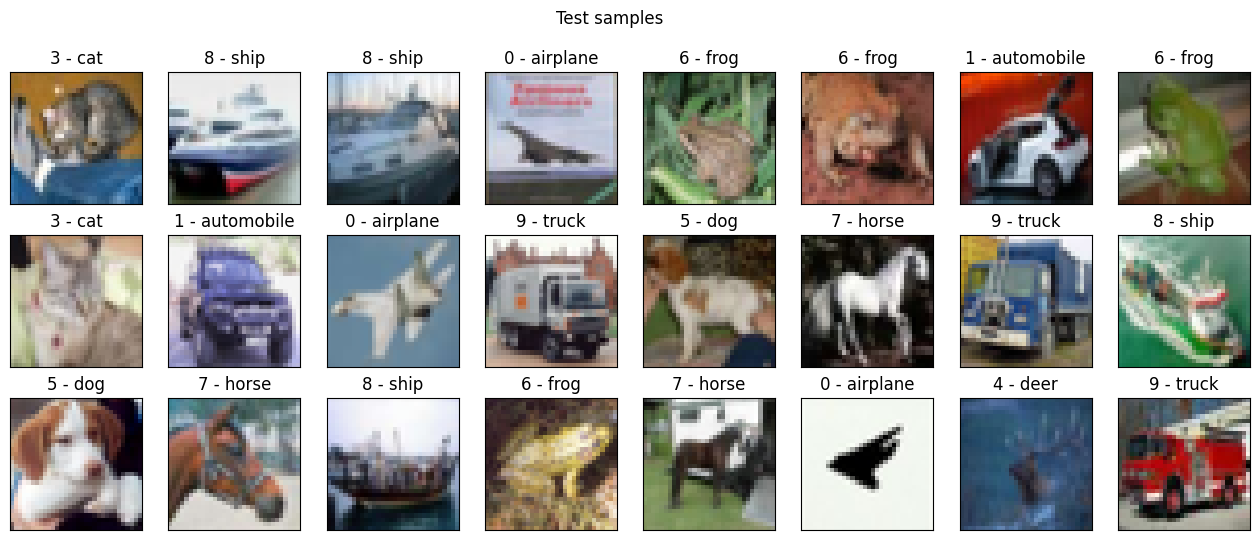

In [8]:
# Результат загрузки:

show_images(train_dataset, 'Train samples')

show_images(test_dataset,'Test samples')

3) Построение архитектуры

* Вывод информации об архитектуре

* Выполнить визуализацию сети

In [9]:
# Парметры
batch_size = 64

in_channels = 3

num_classes = 10

In [10]:
# Разделение данных на пакеты

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False
)

Я буду использовать модель RESNET (используется блок resudial, который добавляет исходные входные данные обратно к выходной карте объектов, полученной путем прохождения входных данных через один или несколько сверточных слоев).

In [12]:
def My_ConvBlock(in_channels, out_channels, aply_pool=False):
  # Слои
  layers_Block = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels,
                    out_channels,
                    kernel_size = 3,
                    padding = 1),
    torch.nn.BatchNorm2d(out_channels),
    torch.nn.ReLU(inplace=True),
  )
  # MaxPool
  if aply_pool:
    layers_Block.append(torch.nn.MaxPool2d(2))
  return layers_Block

In [14]:
class ResNet9_Classifier(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet9_Classifier, self).__init__()

        self.conv1 = My_ConvBlock(in_channels, 64)
        self.conv2 = My_ConvBlock(64, 128, aply_pool=True)
        self.res1 = torch.nn.Sequential(My_ConvBlock(128, 128),
                                        My_ConvBlock(128, 128))

        self.conv3 = My_ConvBlock(128, 256, aply_pool=True)
        self.conv4 = My_ConvBlock(256, 512, aply_pool=True)
        self.res2 = torch.nn.Sequential(My_ConvBlock(512, 512),
                                        My_ConvBlock(512, 512))

        self.classifier = torch.nn.Sequential(torch.nn.MaxPool2d(4),
                                        torch.nn.Flatten(),
                                        torch.nn.Linear(512, num_classes))

    def forward(self, X_batch):
        X_out = self.conv1(X_batch)
        X_out = self.conv2(X_out)

        X_out = self.res1(X_out) + X_out

        X_out = self.conv3(X_out)
        X_out = self.conv4(X_out)

        X_out = self.res2(X_out) + X_out

        X_out = self.classifier(X_out)
        return X_out


Создание модели:

In [15]:
My_ResNet_Classifier = ResNet9_Classifier(in_channels, num_classes)

In [16]:
# Вывод информации об архитектуре
My_ResNet_Classifier

ResNet9_Classifier(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU

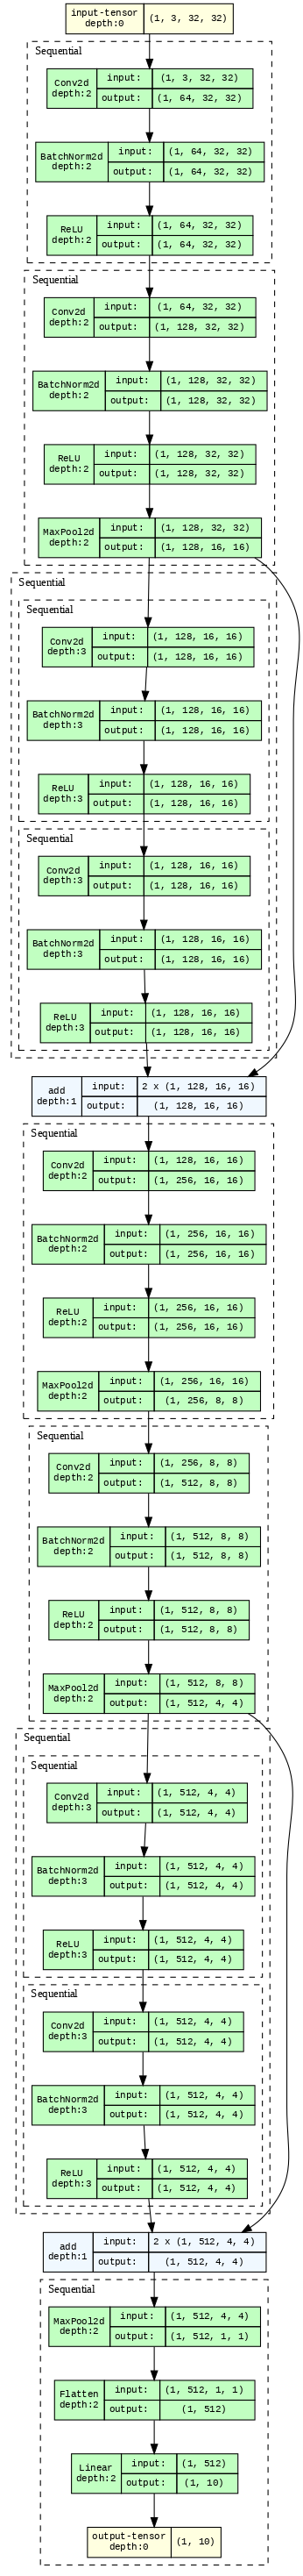

In [17]:
# Визуализация сети
graphviz.set_jupyter_format('png')
My_ResNet_Classifier_draw = draw_graph(My_ResNet_Classifier, input_size=(1,3,32,32), expand_nested=True)
My_ResNet_Classifier_draw.visual_graph

#### 4) Обучение модели

* Вывод информации о параметрах алгоритма обучения

* Вывести **ошибку классификации** на обучении

* Вывести время обучения каждой эпохи

* Вывести **общее время обучения сети**

In [18]:
# Параметры
learning_rate = 0.001
epoch_count = 20


print(f'learnig_rate = {learning_rate}')
print(f'epoch_count = {epoch_count}')
print(f'in_channels = {in_channels}')
print(f'num_classes = {num_classes}')
print(f'batch_size = {batch_size}')

learnig_rate = 0.001
epoch_count = 20
in_channels = 3
num_classes = 10
batch_size = 64


Здесь будем так же использовать оптимизатор.

Оптимизатор — это метод достижения лучших результатов, помощь в ускорении обучения. Другими словами, это алгоритм, используемый для незначительного изменения параметров, таких как веса и скорость обучения, чтобы модель работала правильно и быстро.

В данном случае выберем наиболее часто используемый на практике Алгоритм Адама.

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
My_ResNet_Classifier.to(device)

optimizer = torch.optim.Adam(My_ResNet_Classifier.parameters(), lr = learning_rate)

loss_function = torch.nn.CrossEntropyLoss()

In [26]:
# ТЕСТИРОВАНИЕ
# Вычисление точности
def get_accuracy(model, data_loader):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

# Вычисление функции-потерь
def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

# ТРЕНИРОВКА
# Вычисление точности на пакете данных
def Accuracy_batch(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

# Вычисление точности всех пакетов (на одной эпохе обучения)
def Accuracy_epoch(acc_batches):
  return torch.stack(acc_batches).mean()

# Вычисление функции-потерь всех пакетов (на одной эпохе обучения)
def Loss_epoch(loss_batches):
  return torch.stack(loss_batches).mean()

Обучение модели:

In [22]:
def TrainModel(modelTrain, data, epoch_count, loss_func_batch, optimizer, device):
  print("Обучение:")
  print(' Эпохи:')
  # Устанавливаем время общего обучения
  all_train_time = time.time()
  # Обучение на эпохах
  for epoch in range(epoch_count):
    # Устанавливаем время обучения одной эпохи
    epoch_time = time.time()
    # Точность и потери всех пакетов эпохи
    loss_all_batch = []
    acc_all_batch = []
    # Проход по пакетам данных
    for _, (images, labels) in enumerate(data):

        img_batch = images.to(device)
        labels_batch = labels.to(device)

        optimizer.zero_grad()

        outputs_batch = modelTrain(img_batch)

        loss_batch = loss_func_batch(outputs_batch, labels_batch)
        loss_all_batch.append(loss_batch)

        acc_batch = Accuracy_batch(outputs_batch, labels_batch)
        acc_all_batch.append(acc_batch)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    epoch_time = time.time() - epoch_time

    # Loss (all batches) epoch
    loss_epoch = Loss_epoch(loss_all_batch)
    # Accuracy (all batches) epoch
    acc_epoch = Accuracy_epoch(acc_all_batch)

    # Вывод информации
    print(f'   Эпоха[{epoch + 1}]:')
    print(f'      Loss = {(loss_epoch):.6}. Точность = {(acc_epoch * 100):.6}%. Время = {epoch_time:.4}s')

  all_train_time = time.time() - all_train_time
  print(f'Общее время обучения = {all_train_time}s, или {all_train_time / 60}min')

In [23]:
TrainModel(My_ResNet_Classifier, train_data_loader, epoch_count, loss_function, optimizer, device)

Обучение:
 Эпохи:
   Эпоха[1]:
      Loss = 1.14274. Точность = 59.8306%. Время = 43.25s
   Эпоха[2]:
      Loss = 0.705577. Точность = 75.6813%. Время = 41.01s
   Эпоха[3]:
      Loss = 0.564127. Точность = 80.5986%. Время = 41.46s
   Эпоха[4]:
      Loss = 0.482161. Точность = 83.5398%. Время = 41.45s
   Эпоха[5]:
      Loss = 0.422589. Точность = 85.5339%. Время = 41.47s
   Эпоха[6]:
      Loss = 0.365447. Точность = 87.3681%. Время = 41.14s
   Эпоха[7]:
      Loss = 0.339174. Точность = 88.3072%. Время = 41.25s
   Эпоха[8]:
      Loss = 0.298508. Точность = 89.6599%. Время = 41.07s
   Эпоха[9]:
      Loss = 0.269758. Точность = 90.609%. Время = 42.01s
   Эпоха[10]:
      Loss = 0.250861. Точность = 91.2764%. Время = 41.68s
   Эпоха[11]:
      Loss = 0.232205. Точность = 91.8998%. Время = 41.84s
   Эпоха[12]:
      Loss = 0.202648. Точность = 92.9048%. Время = 41.29s
   Эпоха[13]:
      Loss = 0.181345. Точность = 93.6901%. Время = 42.02s
   Эпоха[14]:
      Loss = 0.177977. Точност

5) Тестирование модели

Вывести ошибку классификации на тестировании

In [27]:
acc_test = get_accuracy(My_ResNet_Classifier, test_data_loader)
loss_test = get_loss(My_ResNet_Classifier, test_data_loader, device)
print(f'Тестовая выборка:')
print(f'  Точность = {(acc_test * 100):.6}%.')
print(f'  Loss = {((loss_test)):.6}%.')

Тестовая выборка:
  Точность = 91.11%.
  Loss = 0.00506407%.
